In [1]:
# Імпорт необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
data = iris.frame

data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
X = data[iris.feature_names]
y = data['target']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [5]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
y.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

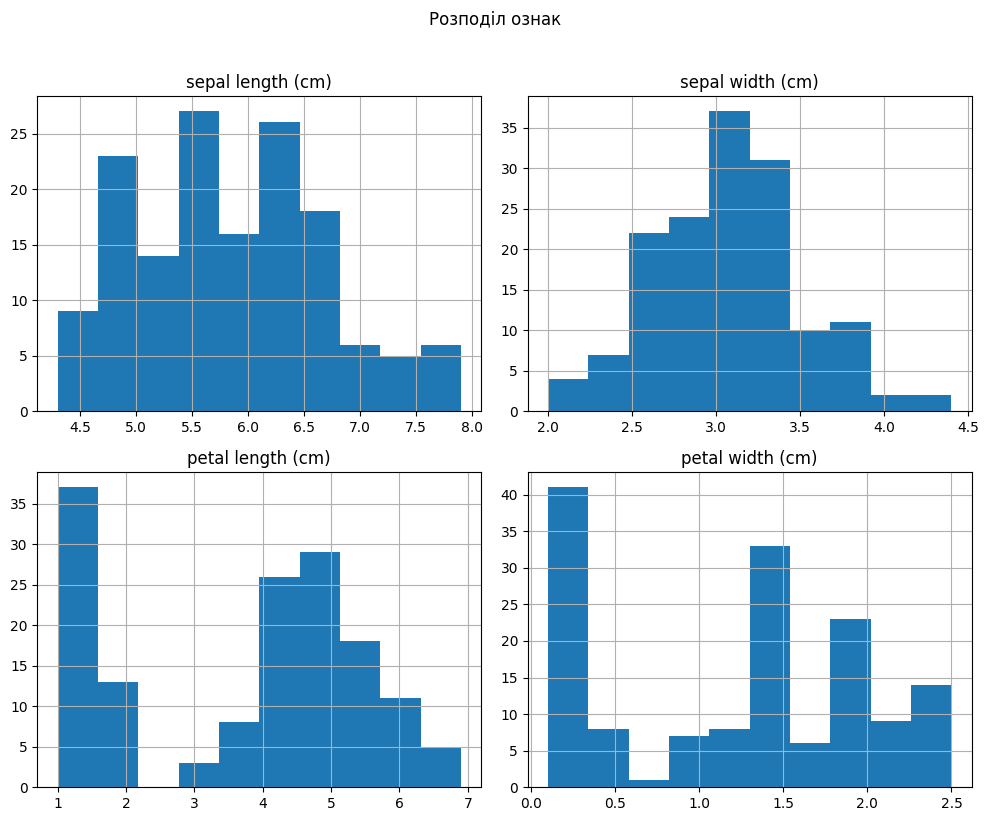

In [7]:
X.hist(figsize=(10, 8))
plt.suptitle("Розподіл ознак", y=1.02)
plt.tight_layout()
plt.show()

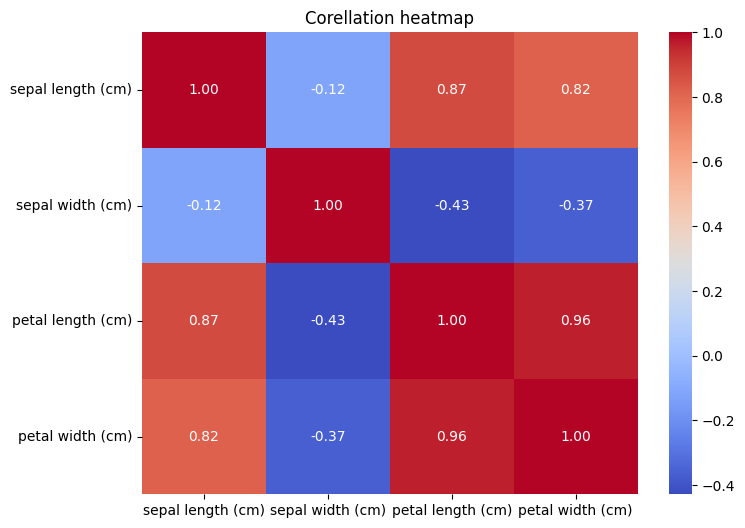

In [8]:
correlation_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corellation heatmap")
plt.show()

In [9]:
X = X.drop('petal width (cm)', axis=1)

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X[:5]

array([[-0.90068117,  1.01900435, -1.34022653],
       [-1.14301691, -0.13197948, -1.34022653],
       [-1.38535265,  0.32841405, -1.39706395],
       [-1.50652052,  0.09821729, -1.2833891 ],
       [-1.02184904,  1.24920112, -1.34022653]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test = encoder.transform(y_test.values.reshape(-1, 1))

In [13]:
VALIDATION_SPLIT = 0.2
N_TRAIN = len(X_train)
N_VALIDATION = N_TRAIN * VALIDATION_SPLIT
BATCH_SIZE = 8
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [14]:
initial_learning_rate = 0.001
decay_steps = STEPS_PER_EPOCH * 50
decay_rate = 0.96
staircase = False

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=staircase
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

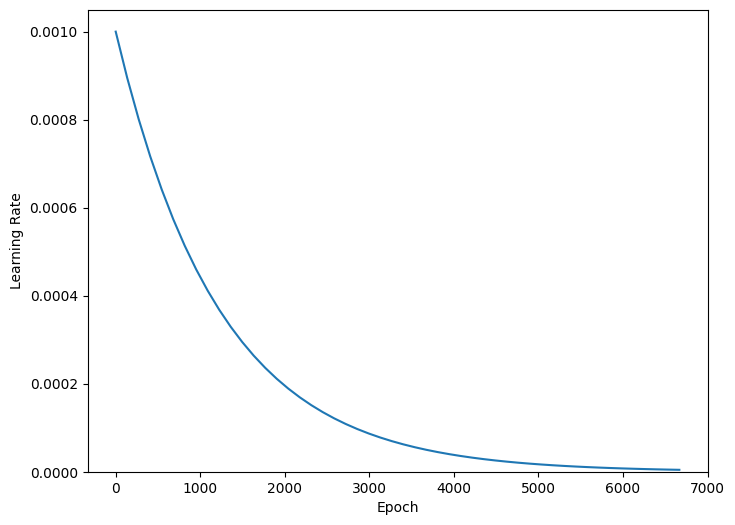

In [15]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [16]:
def get_callbacks():
  return [tf.keras.callbacks. EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
  ]

In [17]:
def compile_and_fit(model, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', 'accuracy'])

    model.summary()

    history = model.fit(
        X_train,
        y_train,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=VALIDATION_SPLIT,
        callbacks=get_callbacks(),
        verbose=0
    )
    return history

In [18]:
from tensorflow.keras.layers import Dropout

def create_model_tiny(input_shape):
    model = Sequential([
        Dense(4, activation='relu', input_shape=input_shape),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_small(input_shape):
    model = Sequential([
        Dense(8, activation='relu', input_shape=input_shape),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_medium(input_shape):
    model = Sequential([
        Dense(16, activation='relu', input_shape=input_shape),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_large(input_shape):
    model = Sequential([
        Dense(32, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_medium_dropout(input_shape, dropout_rate=0.2):
    model = Sequential([
        Dense(16, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def create_model_large_dropout(input_shape, dropout_rate=0.2):
    model = Sequential([
        Dense(32, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(8, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

In [19]:
input_shape = (X_train.shape[1],)


tiny_model = create_model_tiny(input_shape)
tiny_model.summary()
history = compile_and_fit(tiny_model, max_epochs=100)



C:\Users\dmytr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


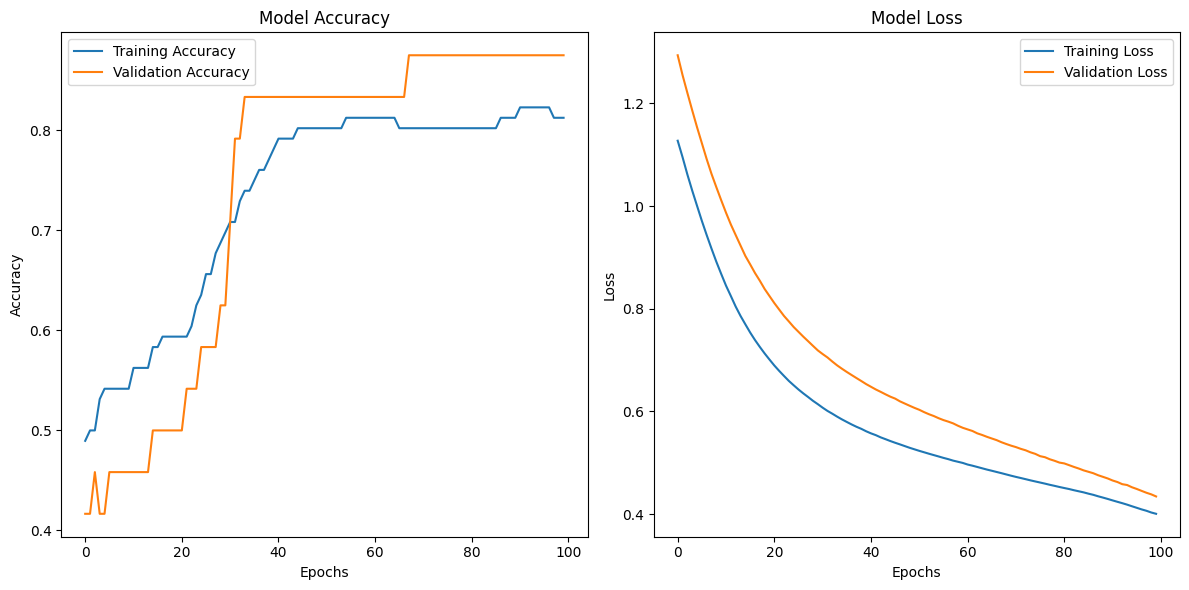

In [20]:
# Plot training and validation accuracy and loss
def draw_plot():
    plt.figure(figsize=(12, 6))

# Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

draw_plot()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

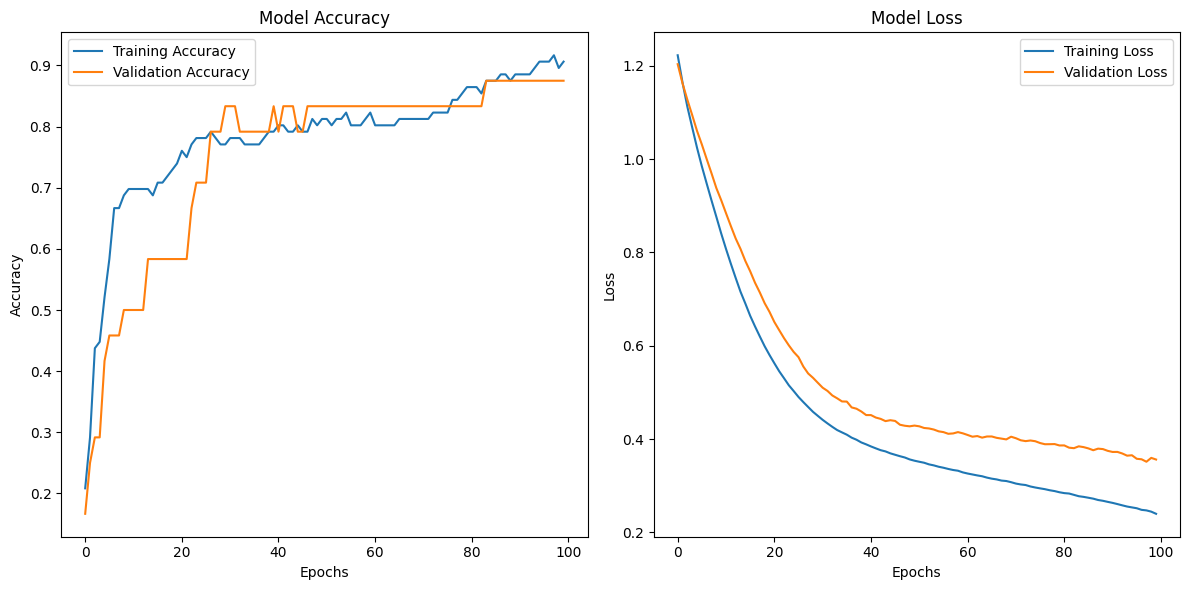

In [21]:
input_shape = (X_train.shape[1],)


small_model = create_model_small(input_shape)
small_model.summary()
history = compile_and_fit(small_model, max_epochs=100)

draw_plot()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499 (1.95 KB)

 Trainable params: 499 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499 (1.95 KB)

 Trainable params: 499 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

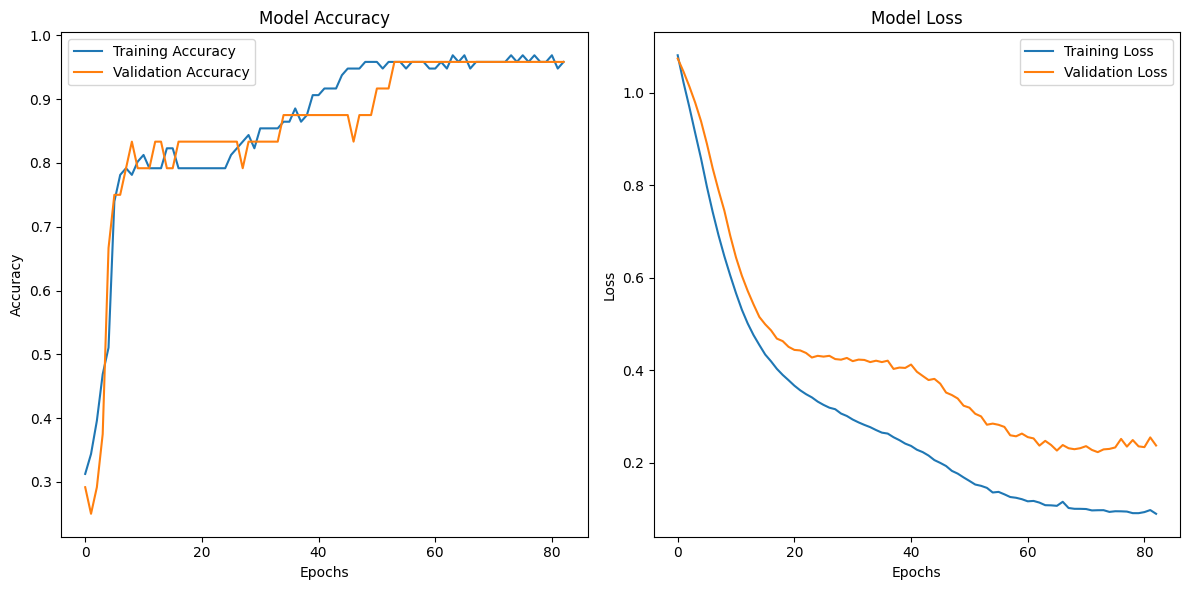

In [22]:
input_shape = (X_train.shape[1],)


medium_model = create_model_medium(input_shape)
medium_model.summary()
history = compile_and_fit(medium_model, max_epochs=100)

draw_plot()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499 (1.95 KB)

 Trainable params: 499 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499 (1.95 KB)

 Trainable params: 499 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

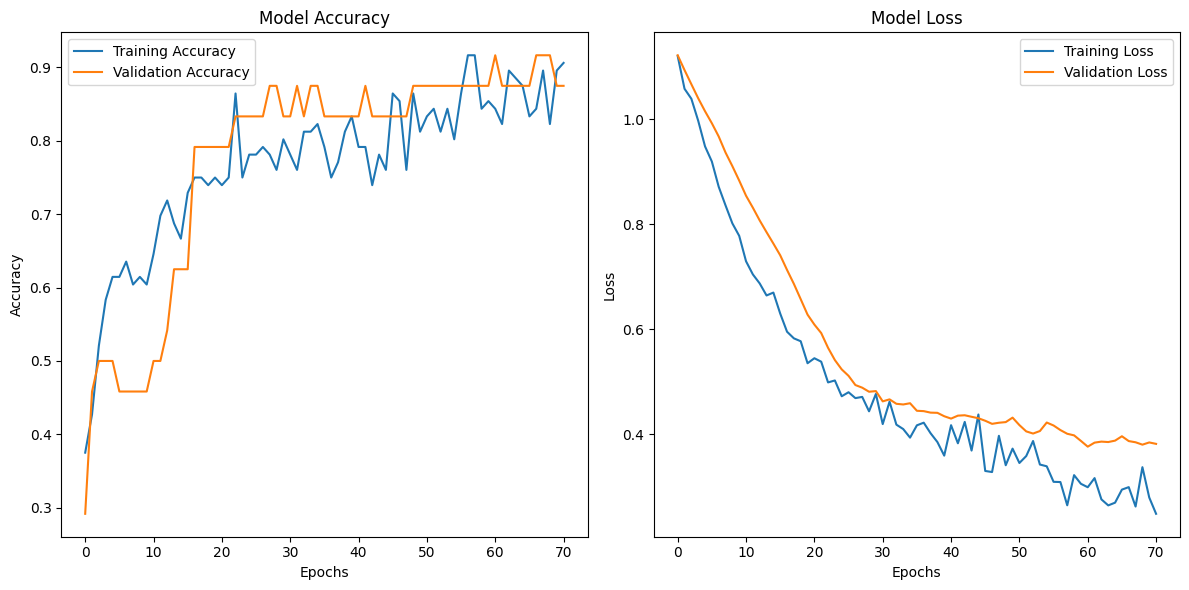

In [23]:
input_shape = (X_train.shape[1],)


medium_model_d = create_model_medium_dropout(input_shape)
medium_model_d.summary()
history = compile_and_fit(medium_model_d, max_epochs=100)

draw_plot()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875 (7.32 KB)

 Trainable params: 1,875 (7.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875 (7.32 KB)

 Trainable params: 1,875 (7.32 KB)

 Non-trainable params: 0 (0.00 B)

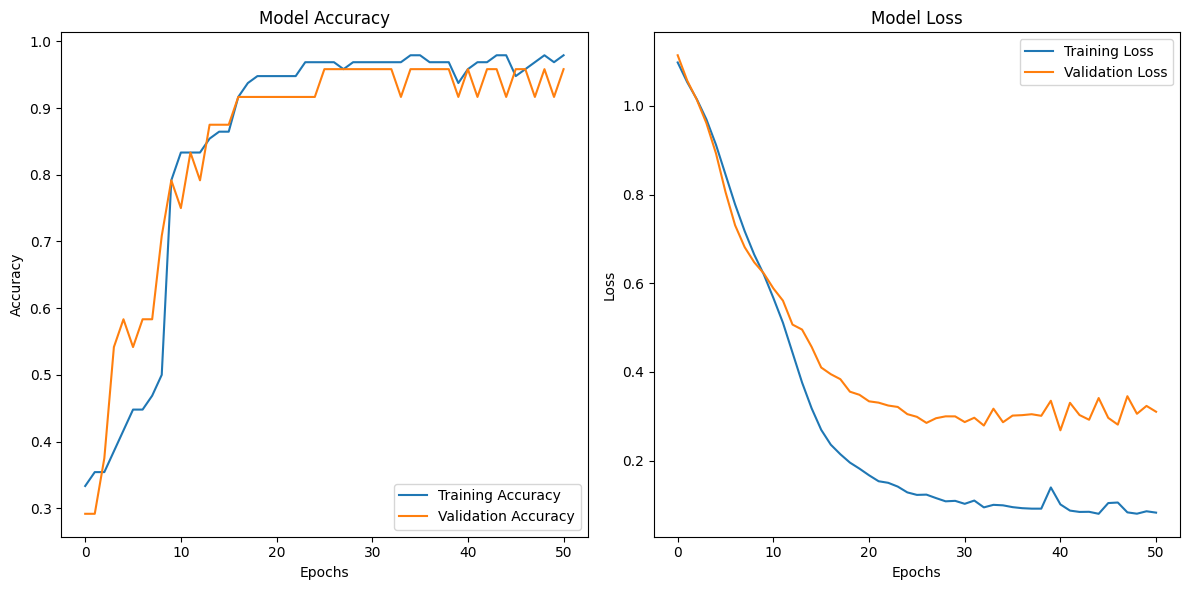

In [24]:
input_shape = (X_train.shape[1],)


large_model = create_model_large(input_shape)
large_model.summary()
history = compile_and_fit(large_model, max_epochs=100)

draw_plot()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875 (7.32 KB)

 Trainable params: 1,875 (7.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875 (7.32 KB)

 Trainable params: 1,875 (7.32 KB)

 Non-trainable params: 0 (0.00 B)

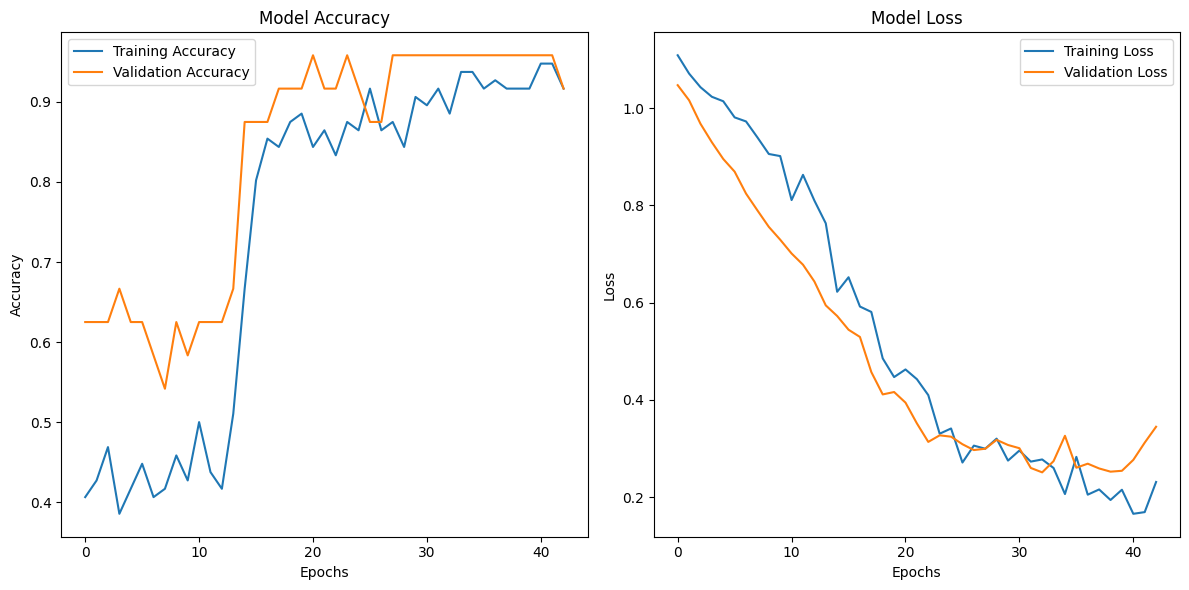

In [25]:
input_shape = (X_train.shape[1],)


large_model_d = create_model_large_dropout(input_shape)
large_model_d.summary()
history = compile_and_fit(large_model_d, max_epochs=100)

draw_plot()

In [26]:
large_model.evaluate(X_test, y_test, verbose=0)


[0.10980795323848724, 0.9666666388511658, 0.9666666388511658]

In [27]:
y_probs = large_model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [28]:
print(y_pred[:5])

[2 0 2 1 1]


In [29]:
print(y_test[:5])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


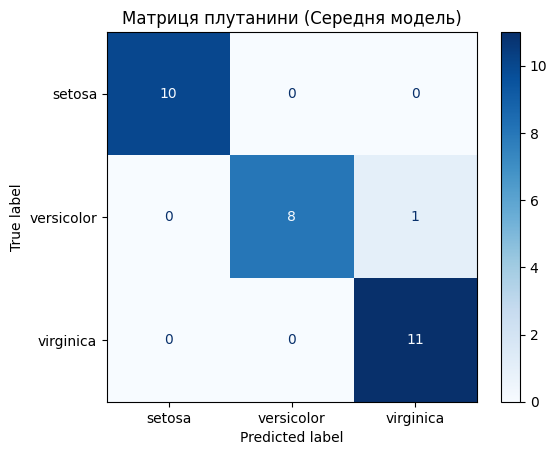


Звіт про класифікацію (Середня модель):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



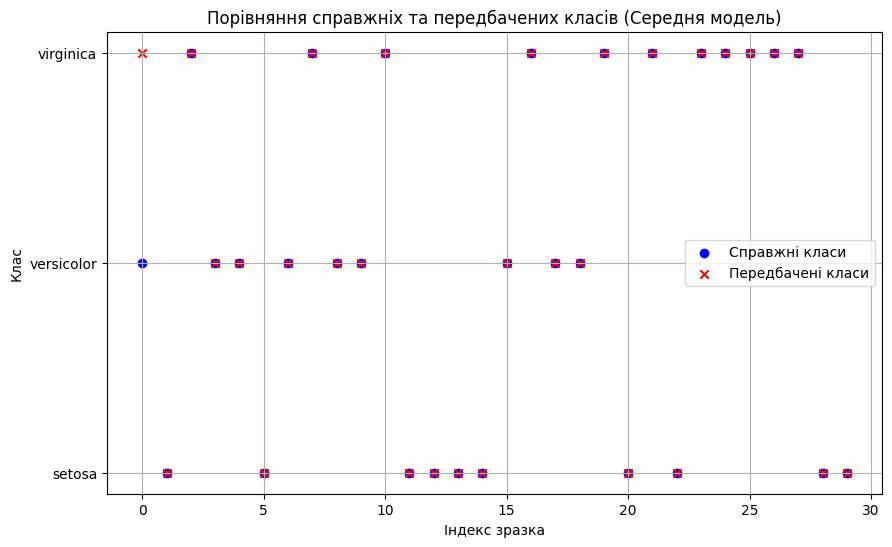

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
y_test_mapped = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_mapped, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Матриця плутанини (Середня модель)')
plt.show()

    # Виведення звіту про класифікацію
print("\nЗвіт про класифікацію (Середня модель):")
print(classification_report(y_test_mapped, y_pred, target_names=iris.target_names))

    # Додаткова візуалізація (графік передбачень проти справжніх значень - обмежено для багатокласової класифікації)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_mapped)), y_test_mapped, color='blue', marker='o', label='Справжні класи')
plt.scatter(range(len(y_pred)), y_pred, color='red', marker='x', label='Передбачені класи')
plt.yticks(np.arange(len(iris.target_names)), iris.target_names)
plt.xlabel('Індекс зразка')
plt.ylabel('Клас')
plt.title('Порівняння справжніх та передбачених класів (Середня модель)')
plt.legend()
plt.grid(True)
plt.show()